### Explore FP Analysis 

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import os
import plotly.express as px
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Load in local csv
folder = '/root/capsule/data/filtered_data_20240911/filtered_data_20240911.csv'
df = pd.read_csv(folder)

df['session_end_time'] = pd.to_datetime(df['session_end_time'])

df['session_end_time'] = df['session_end_time'].dt.date

df.head()

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,water_after_session_last_session,location,session_name,creation_time,subject_genotype,probes,results,results_location,session_time,docDB_status
0,730942,2024-09-10,181826,14.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
1,741211,2024-09-10,181707,14.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741211_2024-09-10_18-17-07,2024-09-10T18:17:07-07:00,wt/wt,[],NaN,NaN,18-17-07,1_uploaded but not processed
2,736198,2024-09-10,181446,14.0,447-2-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_73...,behavior_736198_2024-09-10_18-14-46,2024-09-10T18:14:46-07:00,wt/wt,[],NaN,NaN,18-14-46,1_uploaded but not processed
3,730945,2024-09-10,181112,14.0,447-2-B,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
4,741213,2024-09-10,180831,14.0,447-2-A,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,NaN,s3://aind-private-data-prod-o5171v/behavior_74...,behavior_741213_2024-09-10_18-08-31,2024-09-10T18:08:31-07:00,wt/wt,[],NaN,NaN,18-08-31,1_uploaded but not processed


In [ ]:
# All columns in df
print(df.columns.tolist())

['subject_id', 'session_date', 'nwb_suffix', 'session', 'rig', 'user_name', 'curriculum_name', 'curriculum_version', 'current_stage_actual', 'task', 'notes', 'experiment_description', 'session_start_time', 'session_end_time', 'session_run_time_in_min', 'water_in_session_foraging', 'water_in_session_manual', 'water_in_session_total', 'water_after_session', 'water_day_total', 'base_weight', 'target_weight', 'target_weight_ratio', 'weight_after', 'laser_1_calibration_power', 'laser_2_calibration_power', 'laser_1_target_areas', 'laser_2_target_areas', 'commit_ID', 'repo_url', 'current_branch', 'weight_after_ratio', 'p_reward_sum_mean', 'p_reward_sum_std', 'p_reward_sum_median', 'p_reward_contrast_mean', 'p_reware_contrast_median', 'effective_block_length_mean', 'effective_block_length_std', 'effective_block_length_median', 'effective_block_length_min', 'effective_block_length_max', 'duration_gocue_stop_mean', 'duration_gocue_stop_std', 'duration_gocue_stop_median', 'duration_gocue_stop_min

#### Variable Correlation
____

In [ ]:
main_df = df[['subject_id', 'curriculum_name', 'current_stage_actual', 'session_end_time', 'subject_genotype','session_run_time_in_min', 'p_reward_sum_mean', 'effective_block_length_mean', 'duration_gocue_stop_mean', 'duration_delay_period_mean', 'duration_iti_mean', 'finished_rate', 'reward_rate', 'foraging_eff', 'reaction_time_mean', 'avg_trial_length_in_seconds']]

main_df = main_df.dropna().copy()

# By sub selecting these variables, decreasing the sample size significantly, will affect model

variable_corr_df = main_df[(main_df['curriculum_name'] == 'Uncoupled Baiting') & (df['current_stage_actual'] == 'GRADUATED')][['subject_id', 'session_end_time', 'foraging_eff', 'session_run_time_in_min', 'p_reward_sum_mean', 'effective_block_length_mean', 'duration_gocue_stop_mean', 'duration_delay_period_mean', 'duration_iti_mean', 'finished_rate', 'reward_rate', 'reaction_time_mean', 'avg_trial_length_in_seconds']]

print(variable_corr_df[['session_run_time_in_min', 'finished_rate', 'effective_block_length_mean']].describe())


       session_run_time_in_min  finished_rate  effective_block_length_mean
count                42.000000      42.000000                    42.000000
mean                 75.357143       0.907764                    17.192336
std                  11.495113       0.127892                     2.039754
min                  38.000000       0.369565                    14.400000
25%                  75.000000       0.866505                    15.894725
50%                  75.000000       0.956178                    16.727778
75%                  80.000000       0.990341                    17.491071
max                  90.000000       1.000000                    22.363636


/tmp/ipykernel_21246/2941840316.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  variable_corr_df = main_df[(main_df['curriculum_name'] == 'Uncoupled Baiting') & (df['current_stage_actual'] == 'GRADUATED')][['subject_id', 'session_end_time', 'foraging_eff', 'session_run_time_in_min', 'p_reward_sum_mean', 'effective_block_length_mean', 'duration_gocue_stop_mean', 'duration_delay_period_mean', 'duration_iti_mean', 'finished_rate', 'reward_rate', 'reaction_time_mean', 'avg_trial_length_in_seconds']]


In [ ]:
# Function to standardize correlation variables

def standardize(series):
    normalize = (series - series.mean()) / series.std()
    return normalize

#### Comparing iti to foraging efficiency
____

In [ ]:
# Create dataframe for iti plot - uncoupled baiting & graduated with iti_mean and foraging efficacy 
iti_df = df[(df['curriculum_name'] == 'Uncoupled Baiting') & (df['current_stage_actual'] == 'GRADUATED')][['subject_id', 'session_end_time', 'duration_iti_mean', 'foraging_eff']]
iti_df = iti_df.sort_values('subject_id')

print(len(iti_df['duration_iti_mean'].unique()))
print(len(iti_df['subject_id'].unique()))


iti_df.head()

112
18


,subject_id,session_end_time,duration_iti_mean,foraging_eff
2513,703548,2024-03-18,3.925256,0.838633
2487,703548,2024-03-20,3.811524,0.848966
2499,703548,2024-03-19,4.114403,0.836394
2451,704151,2024-03-22,3.987650,0.835659
2558,704151,2024-03-14,3.910000,0.730419


<Figure size 1400x600 with 0 Axes>

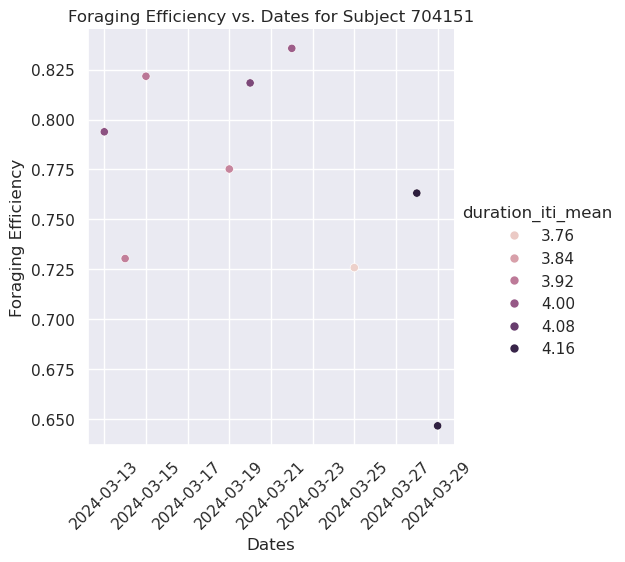

In [ ]:
subject_id = 704151

iti_df_filtered = iti_df[iti_df['subject_id'] == subject_id]

sns.set_theme()

plt.figure(figsize=(14,6))

sns.relplot(data=iti_df_filtered, x='session_end_time', y='foraging_eff', hue='duration_iti_mean', marker='o', zorder=2)

plt.xlabel('Dates')
plt.ylabel('Foraging Efficiency')
plt.title(f'Foraging Efficiency vs. Dates for Subject {subject_id}')
plt.xticks(rotation = 45)
plt.grid(True)

plt.show()


<Figure size 1600x600 with 0 Axes>

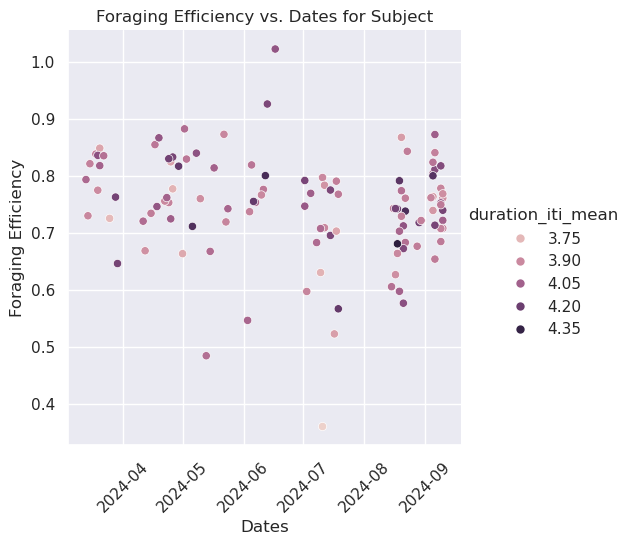

In [ ]:


plt.figure(figsize=(16,6))

sns.relplot(data=iti_df, x='session_end_time', y='foraging_eff', hue='duration_iti_mean', marker='o', zorder=2)

plt.xlabel('Dates')
plt.ylabel('Foraging Efficiency')
plt.title(f'Foraging Efficiency vs. Dates for Subject')
plt.xticks(rotation = 45)
plt.grid(True)

plt.show()

#### Comparing stages to averaged foraging efficiency
____

In [ ]:
# Check dimensions and content of dataframe for variables of interest: 

# Find all instances of unique subject ids
ids = df['subject_id'].unique()
print(f'number of unique ids: {len(ids)}')

# Find total stage count
num_stage = df['current_stage_actual'].unique()
stages = df['current_stage_actual']

# Find total foraging efficiency value count 
forag_eff_count = df['foraging_eff']

# Find total dates assigned per foraging efficiency score 
session_end_times_count = df['session_end_time'].unique()

print(f'types of stages: {num_stage}, number of total stages {len(stages)}')

print(f'number of assigned dates {len(session_end_times_count)}')

print(f'number of forag eff scores: {len(forag_eff_count)}')

number of unique ids: 183
types of stages: ['GRADUATED' 'STAGE_3' 'STAGE_1_WARMUP' 'STAGE_1' 'STAGE_FINAL' 'STAGE_2'
 'STAGE_4' nan], number of total stages 3763
number of assigned dates 283
number of forag eff scores: 3763


In [ ]:
# Create new foraging efficiency df
fe_df = df[['subject_id', 'current_stage_actual','session_end_time','foraging_eff']]

print(fe_df.shape)
fe_df.head(30)

(3763, 4)


,subject_id,current_stage_actual,session_end_time,foraging_eff
0,730942,GRADUATED,2024-09-10,0.761435
1,741211,GRADUATED,2024-09-10,0.768945
2,736198,GRADUATED,2024-09-10,0.708424
3,730945,GRADUATED,2024-09-10,0.722345
4,741213,GRADUATED,2024-09-10,0.740106
5,753126,STAGE_3,2024-09-10,0.567419
6,728568,STAGE_1_WARMUP,2024-09-10,0.805369
7,743794,STAGE_1_WARMUP,2024-09-10,0.788745
8,728570,STAGE_1_WARMUP,2024-09-10,0.652372
9,741210,STAGE_1_WARMUP,2024-09-10,0.799051


In [ ]:
# Confirm num of stages == num of assigned dates for a given subject id
print(fe_df.loc[fe_df['subject_id'] == 730942, 'session_end_time'])
print(fe_df.loc[fe_df['subject_id'] == 730942, 'current_stage_actual'])

0      2024-09-10
21     2024-09-09
49     2024-09-06
78     2024-09-05
103    2024-09-04
132    2024-09-03
145    2024-09-02
150    2024-09-01
155    2024-08-31
160    2024-08-30
182    2024-08-29
205    2024-08-28
230    2024-08-27
238    2024-08-26
Name: session_end_time, dtype: object
0           GRADUATED
21          GRADUATED
49          GRADUATED
78          GRADUATED
103       STAGE_FINAL
132       STAGE_FINAL
145       STAGE_FINAL
150       STAGE_FINAL
155       STAGE_FINAL
160       STAGE_FINAL
182           STAGE_3
205           STAGE_2
230           STAGE_2
238    STAGE_1_WARMUP
Name: current_stage_actual, dtype: object


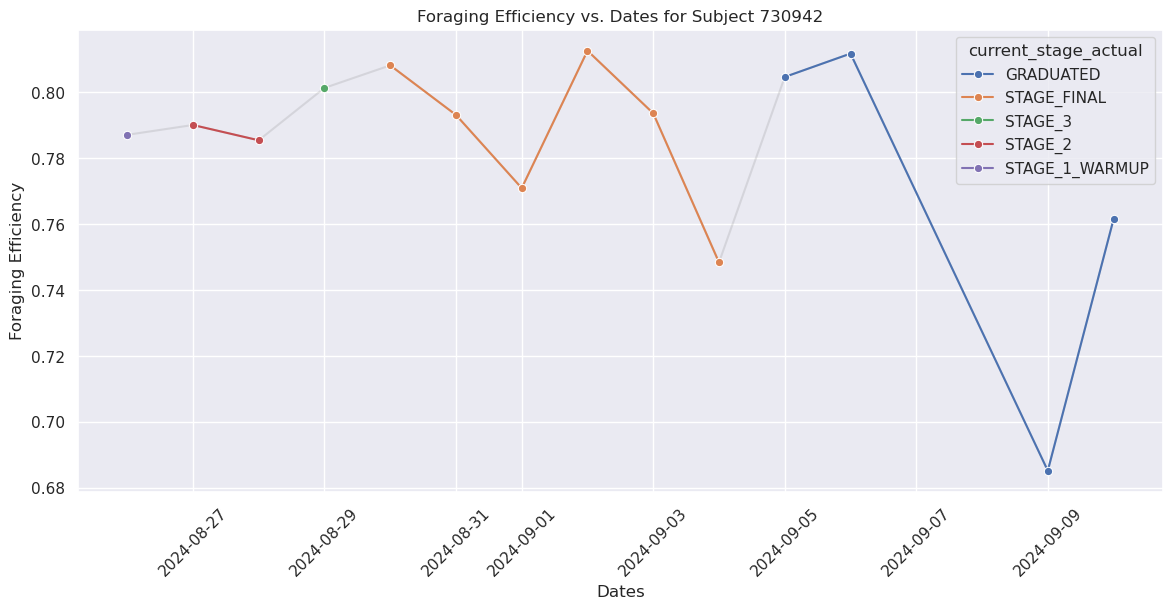

In [ ]:
# Plotting for 1 subject id over corresponding dates 

subject_id = 730942

# Filter for selected subject id and create new dataframe for only that subject id
fe_df_filtered = fe_df[fe_df['subject_id'] == subject_id]

plt.figure(figsize=(14, 6))

plt.plot(fe_df_filtered['session_end_time'], fe_df_filtered['foraging_eff'], color='grey', alpha=0.2, zorder=1)

sns.lineplot(data=fe_df_filtered, x='session_end_time', y='foraging_eff', hue='current_stage_actual', marker='o', zorder=2)

plt.xlabel('Dates')
plt.ylabel('Foraging Efficiency')
plt.title(f'Foraging Efficiency vs. Dates for Subject {subject_id}')
plt.xticks(rotation = 45)
plt.grid(True)

plt.show()

#### Comparing genotypes to averaged foraging efficiency

In [ ]:
geno_df = df[['subject_id', 'subject_genotype', 'session_end_time','foraging_eff']]

geno_df = geno_df.sort_values(['subject_genotype', 'session_end_time'])

geno_df.head(40)

,subject_id,subject_genotype,session_end_time,foraging_eff
1348,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-10,0.714286
1321,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-11,0.705846
1298,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-12,0.505319
1212,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-20,0.779528
1187,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-21,0.673098
1167,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-24,0.754302
1149,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-25,0.790120
1125,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-26,0.669084
1107,724584,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-06-27,0.653946
373,715095,Ai148(TIT2L-GC6f-ICL-tTA2)/wt,2024-08-19,0.760048


In [ ]:
# Find all instances of unique subject ids
ids = geno_df['subject_id'].unique()
print(f'number of unique ids: {len(ids)}')

# Find total stage count
num_geno = geno_df['subject_genotype'].unique()
genos = geno_df['subject_genotype']

# Find total foraging efficiency value count 
forag_eff_count = geno_df['foraging_eff']

# Find total dates assigned per foraging efficiency score 
session_end_times_count = geno_df['session_end_time'].unique()

print(f'types of genotypes: {num_geno}, number of total genotypes {len(genos)}')

print(f'number of assigned dates {len(session_end_times_count)}')

print(f'number of forag eff scores: {len(forag_eff_count)}')

number of unique ids: 183
types of genotypes: ['Ai148(TIT2L-GC6f-ICL-tTA2)/wt' 'Dbh-Cre-KI/wt'
 'Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-tTA2-WPRE)/wt'
 'Fos2A-iCreER/wt;Ai75(RCL-nT)/wt' 'Gad2-IRES-Cre/Gad2-IRES-Cre'
 'Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9)' 'Pdyn-IRES-Cre/Pdyn-IRES-Cre'
 'Sert-Cre/wt' 'Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt' 'Slc32a1-IRES-Cre/wt'
 'Slc6a3-IRES-Cre_Bkmn/wt' 'VGAT-ChR2-YFP/wt' 'wt/wt' nan], number of total genotypes 3763
number of assigned dates 283
number of forag eff scores: 3763


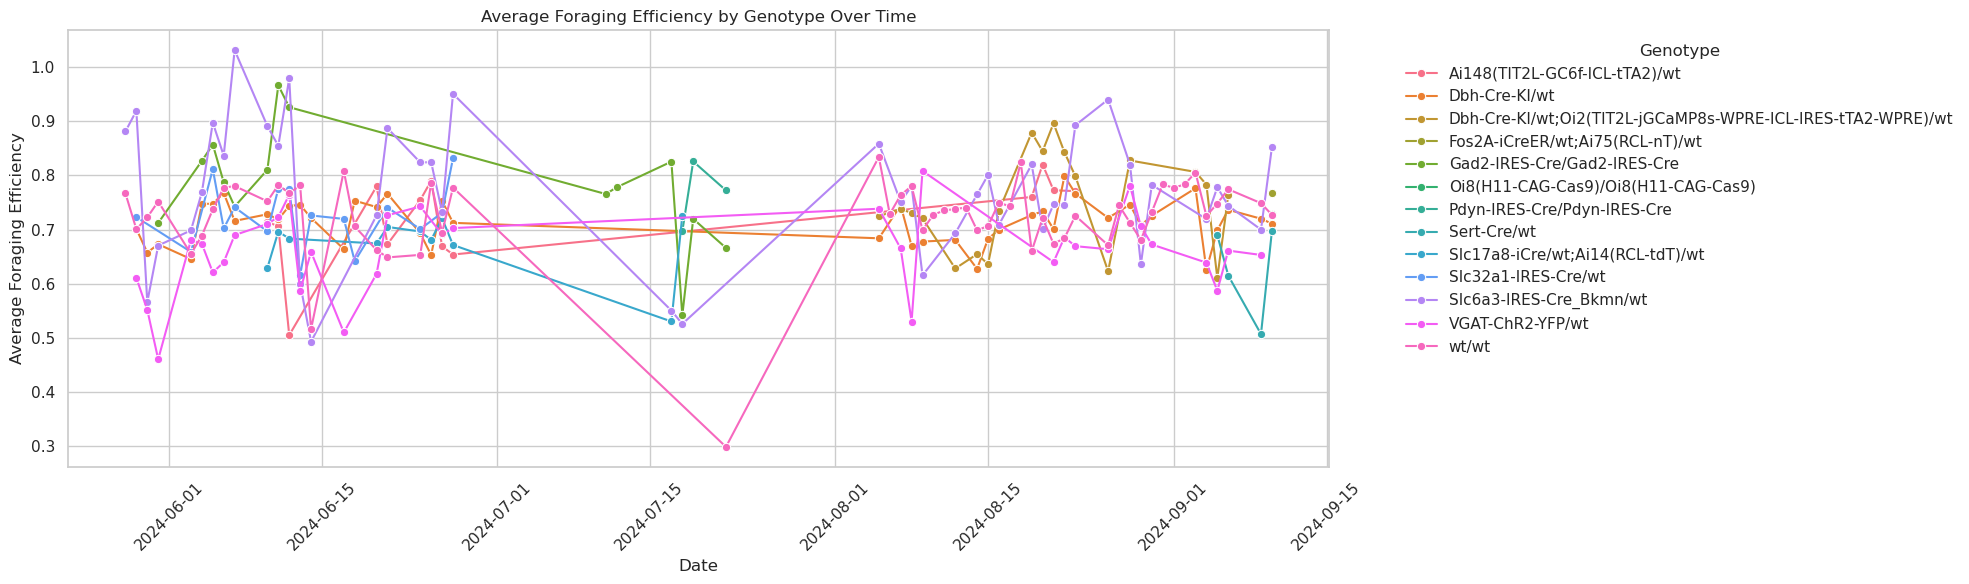

                                                    count      mean       std  \
subject_genotype                                                                
Ai148(TIT2L-GC6f-ICL-tTA2)/wt                        13.0  0.720680  0.082681   
Dbh-Cre-KI/wt                                        44.0  0.713916  0.040147   
Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-...   19.0  0.749528  0.089062   
Fos2A-iCreER/wt;Ai75(RCL-nT)/wt                       1.0  0.768072       NaN   
Gad2-IRES-Cre/Gad2-IRES-Cre                          14.0  0.780276  0.106144   
Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9)                   1.0  0.728871       NaN   
Pdyn-IRES-Cre/Pdyn-IRES-Cre                           3.0  0.764816  0.064837   
Sert-Cre/wt                                           4.0  0.627429  0.088281   
Slc17a8-iCre/wt;Ai14(RCL-tdT)/wt                     11.0  0.673968  0.054327   
Slc32a1-IRES-Cre/wt                                  16.0  0.724327  0.057402   
Slc6a3-IRES-Cre_Bkmn/wt     

In [ ]:
# plot average foraging efficiency over time

# Sort the dataframe by date
geno_df = geno_df.sort_values('session_end_time')


# Group by genotype, date, and calculate mean foraging efficiency 
grouped_df = geno_df.groupby(['subject_genotype', 'session_end_time'])['foraging_eff'].mean().reset_index()


# Plot grouped dataframe 
plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")

sns.lineplot(data=grouped_df, x='session_end_time', y='foraging_eff', hue='subject_genotype', marker='o')

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='best', frameon=False)

plt.tight_layout()
plt.show()

print(grouped_df.groupby('subject_genotype')['foraging_eff'].describe())

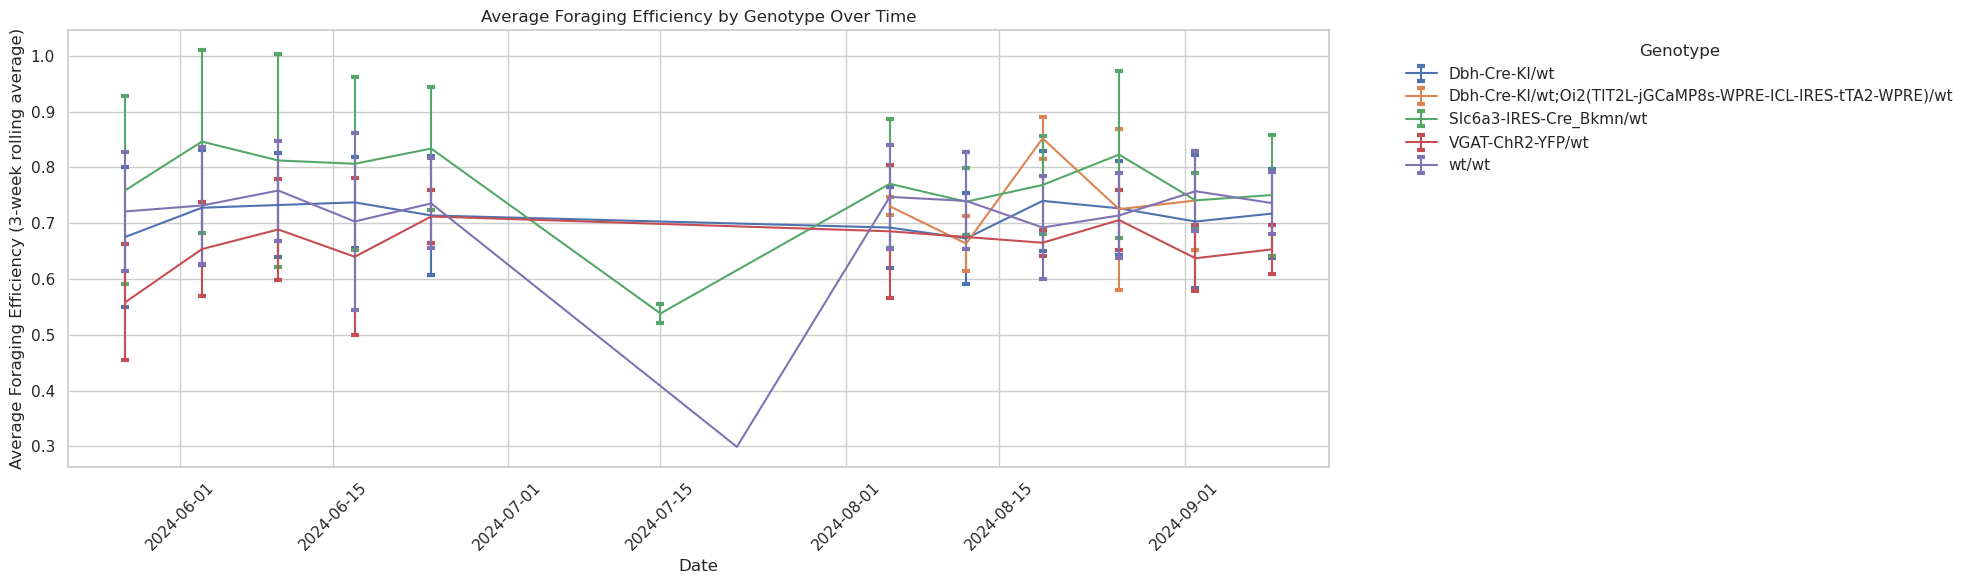

                                                    mean                      \
                                                   count      mean       std   
subject_genotype                                                               
Dbh-Cre-KI/wt                                       11.0  0.712673  0.023841   
Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-...   5.0  0.742366  0.068362   
Slc6a3-IRES-Cre_Bkmn/wt                             12.0  0.765742  0.080715   
VGAT-ChR2-YFP/wt                                    10.0  0.659960  0.044206   
wt/wt                                               12.0  0.694689  0.126178   

                                                                        \
                                                         min       25%   
subject_genotype                                                         
Dbh-Cre-KI/wt                                       0.672821  0.697656   
Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-...  0.663454  0

In [ ]:
# Making a cleaner plot / add std

geno_df['session_end_time'] = pd.to_datetime(geno_df['session_end_time'])

# Group by genotype and week
geno_df['week'] = geno_df['session_end_time'].dt.to_period('W')
grouped_df = geno_df.groupby(['subject_genotype', 'week'])['foraging_eff'].agg(['mean', 'std']).reset_index() # Calculate mean foraging efficiency 
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()


# Take only top 5 most common genotypes in df
top_n_genotypes = geno_df['subject_genotype'].value_counts().nlargest(5).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


# Plot dataframe
plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")

# Plot average foraging efficiency for each genotype 
for genotype in grouped_df['subject_genotype'].unique():
    data = grouped_df[grouped_df['subject_genotype'] == genotype]
    plt.errorbar(data['week'], data['mean'], yerr=data['std'], label=genotype, capsize=3, capthick=3)

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='best', frameon = False)

plt.tight_layout()
plt.show()

print(grouped_df.groupby('subject_genotype')[['mean', 'std']].describe())

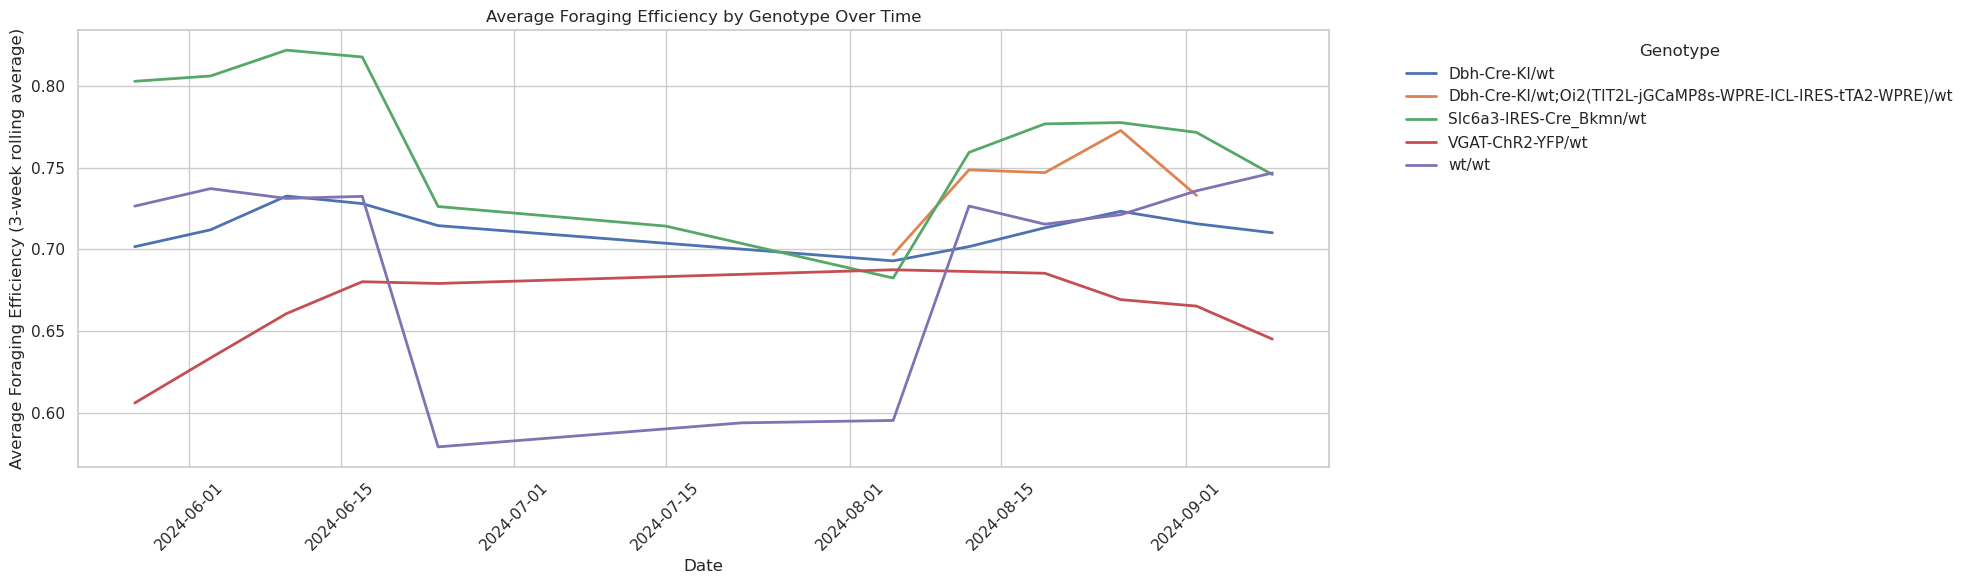

                                                    count      mean       std  \
subject_genotype                                                                
Dbh-Cre-KI/wt                                        11.0  0.713250  0.011785   
Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-...    5.0  0.739620  0.027811   
Slc6a3-IRES-Cre_Bkmn/wt                              12.0  0.766819  0.043362   
VGAT-ChR2-YFP/wt                                     10.0  0.661276  0.026026   
wt/wt                                                12.0  0.695131  0.064252   

                                                         min       25%  \
subject_genotype                                                         
Dbh-Cre-KI/wt                                       0.693000  0.705933   
Dbh-Cre-KI/wt;Oi2(TIT2L-jGCaMP8s-WPRE-ICL-IRES-...  0.696918  0.732980   
Slc6a3-IRES-Cre_Bkmn/wt                             0.682504  0.740859   
VGAT-ChR2-YFP/wt                                    0.606131  

In [ ]:

grouped_df = geno_df.groupby(['subject_genotype', 'week'])['foraging_eff'].mean().reset_index()
grouped_df['week'] = grouped_df['week'].dt.to_timestamp()

# Use 3-week rolling average
grouped_df = grouped_df.sort_values(['subject_genotype', 'week'])
grouped_df['rolling_avg'] = grouped_df.groupby('subject_genotype')['foraging_eff'].rolling(window=3, center=True, min_periods=1).mean().reset_index(0, drop=True)


top_n_genotypes = geno_df['subject_genotype'].value_counts().nlargest(5).index
grouped_df = grouped_df[grouped_df['subject_genotype'].isin(top_n_genotypes)]


plt.figure(figsize=(20, 6))
sns.set_style("whitegrid")

sns.lineplot(data=grouped_df, x='week', y='rolling_avg', hue='subject_genotype', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Average Foraging Efficiency (3-week rolling average)')
plt.title('Average Foraging Efficiency by Genotype Over Time')
plt.xticks(rotation=45)
plt.legend(title='Genotype', bbox_to_anchor=(1.05, 1), loc='upper left', frameon = False)

plt.tight_layout()
plt.show()

print(grouped_df.groupby('subject_genotype')['rolling_avg'].describe())